In [ ]:
!pip install imutils
!pip install tensorflow
!pip install dlib

In [4]:
import json
import boto3
import dlib
import cv2
import time
from scipy.spatial import distance
from imutils import face_utils
import imutils
import os
import numpy as np
import time
import datetime
import json
import base64
import numpy as np
from PIL import Image
import s3fs
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def read_from_s3():

    X = []
    
    fs = s3fs.S3FileSystem()

    for file in fs.ls():
        fname,fext = os.path.splitext(os.path.basename(file))
        if(fext == '.mp4'):
            continue
        with fs.open(f's3://{file}') as f:

            X.append(np.asarray(Image.open(f)))
    
    X = np.array(X)
    
    return X



In [141]:

def plotData(X):
    plt.figure(figsize=(10,10))
    for i in range(len(X)):
        plt.subplot(3,4,i+1)
        plt.imshow(X[i])    

In [8]:
y = []
train_images = []

class drowsyDetector:
    

    def __init__(self):

        self.flag = 0
        self.frame_check = 15
        self.eye_thresh = 0.22
        self.yawn_thres = 0.58
        
        self.lStart,self.lEnd = face_utils.FACIAL_LANDMARKS_68_IDXS["left_eye"]
        self.rStart,self.rEnd = face_utils.FACIAL_LANDMARKS_68_IDXS["right_eye"]
        self.mStart,self.mEnd = face_utils.FACIAL_LANDMARKS_68_IDXS["mouth"]
            
        self.detect = dlib.get_frontal_face_detector()
        self.predict = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

        self.severe_count = 0
        self.region = 'us-east-1'
        self.service = 'es'

    def eye_aspect_ratio(self,eye):

        A = distance.euclidean(eye[1], eye[5])
        B = distance.euclidean(eye[2], eye[4])
        C = distance.euclidean(eye[0], eye[3])
        ear = (A + B) / (2.0 * C)

        return ear

    def mouth_aspect_ratio(self,m):

        A = distance.euclidean(m[3],m[9])
        B = distance.euclidean(m[0],m[7])
        mar = A/B

        return mar

    def gencam(self,frames=[]):
        
        
        global train_images,y
        for frame in frames:

            #print(frame.shape)
            
            frame = imutils.resize(frame, width=450)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            subjects = self.detect(gray, 0)
                 
            for subject in subjects:

                shape = self.predict(gray, subject)
                shape = face_utils.shape_to_np(shape)  # converting to NumPy Array
                leftEye = shape[self.lStart:self.lEnd]
                rightEye = shape[self.rStart:self.rEnd]
                mouth = shape[self.mStart:self.mEnd]

                leftEAR = self.eye_aspect_ratio(leftEye)
                rightEAR = self.eye_aspect_ratio(rightEye)
                mouthEAR = self.mouth_aspect_ratio(mouth)

                ear = (leftEAR + rightEAR) / 2.0

                leftEyeHull = cv2.convexHull(leftEye)
                rightEyeHull = cv2.convexHull(rightEye)
                mouthHull = cv2.convexHull(mouth)

                cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
                cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)
                cv2.drawContours(frame,[mouthHull],-1,(0,255,255),1)

                #print('Eye ratio ',ear)
                #print('Mouth Ratio ',mouthEAR)
            
                if(ear <= self.eye_thresh or mouthEAR >= self.yawn_thres): 
                    y.append(1)
                
                else:
                    y.append(0)
                
                
                train_images.append(gray)
        
        y = np.array(y)
        train_images = np.array(train_images)
            

In [9]:
X = read_from_s3('s3://userphotos-b1-w')
plotData(X[300:312])
dd = drowsyDetector()
dd.gencam(X)

In [91]:
#Splitting data into train and test for evaluation 

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(train_images,y,shuffle=True,test_size=0.2)

In [163]:
#Training the model
checkpoint_filepath = './' + 'model_weights-{epoch}.hdf5'
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = train_images.shape[1:]), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(64,activation=tf.nn.relu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

best_weight_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='auto',
    save_best_only=True,
    save_freq=4,
    verbose=1)

model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['Accuracy'])

In [164]:
history = model.fit(X_train, y_train, epochs=50,verbose=1,callbacks=[best_weight_checkpoint])

Epoch 1/50
 3/11 [=======>......................] - ETA: 0s - loss: 4981.6812 - accuracy: 0.5295
Epoch 00001: accuracy improved from -inf to 0.53906, saving model to ./model_weights-1.hdf5
 7/11 [==================>...........] - ETA: 0s - loss: 5283.7839 - accuracy: 0.5228
Epoch 00001: accuracy did not improve from 0.53906
11/11 [==============================] - 1s 55ms/step - loss: 4564.7218 - accuracy: 0.5062
Epoch 2/50
 1/11 [=>............................] - ETA: 0s - loss: 1058.9314 - accuracy: 0.4375
Epoch 00002: accuracy did not improve from 0.53906
 5/11 [============>.................] - ETA: 0s - loss: 730.2321 - accuracy: 0.4634
Epoch 00002: accuracy did not improve from 0.53906
 9/11 [=======================>......] - ETA: 0s - loss: 547.6366 - accuracy: 0.5010
Epoch 00002: accuracy improved from 0.53906 to 0.57986, saving model to ./model_weights-2.hdf5
11/11 [==============================] - 1s 54ms/step - loss: 494.0654 - accuracy: 0.5244
Epoch 3/50
 1/11 [=>.........

In [80]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [104]:
_,accuracy = model.evaluate(X_test,y_test)
y_p = model.predict(X_test)
y_pred = []
for y_ in y_p:
    if(y_ < 0.5):
        y_pred.append(0)
    else:
        y_pred.append(1)

In [113]:
scores = precision_recall_fscore_support(y_test,y_pred)

print('Accuracy:',accuracy)
print('Precision:',scores[0][1])
print('Recall:',scores[1][1])
print('fscore:',scores[2][1])

Accuracy: 0.7976190447807312
Precision: 0.7884615384615384
Recall: 0.9534883720930233
fscore: 0.8631578947368421


0--> No Alert
1--> Alert


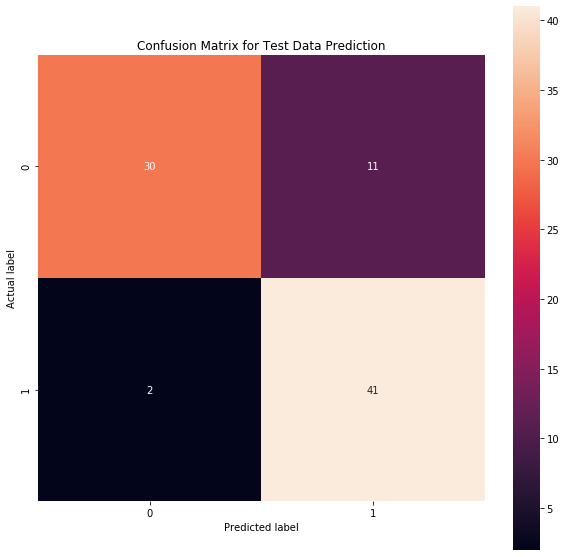

In [159]:
import seaborn as sns

def plot_confusion_matrix(conf_matrix):
    
    plt.figure(figsize=(10,10))
    sns.heatmap(conf_matrix, annot= True, square = True)
    plt.title('Confusion Matrix for Test Data Prediction')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(conf_matrix)
print('0--> No Alert')
print('1--> Alert')

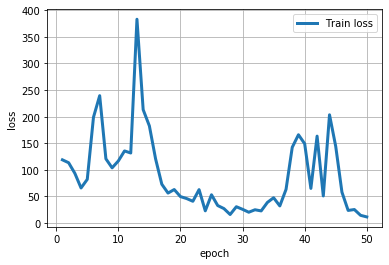

In [137]:
import matplotlib.pyplot as plt1

def accuracyPlot(history,name):
    
    EPOCHS = 50
    plt1.plot(range(1,EPOCHS+1),history[f'{name}'],'-',linewidth=3,label=f'Train {name}')
    plt1.xlabel('epoch')
    plt1.ylabel(f'{name}')
    plt1.grid(True)
    plt1.legend()
    
    
def lossPlot(history,name):
    EPOCHS = 50
    plt.plot(range(1,EPOCHS+1),history[f'{name}'],'-',linewidth=3,label=f'Train {name}')
    plt.xlabel('epoch')
    plt.ylabel(f'{name}')
    plt.grid(True)
    plt.legend()
    
lossPlot(history.history,'loss')

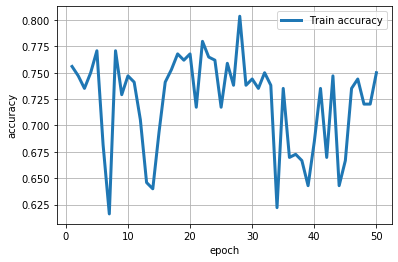

In [138]:
accuracyPlot(history.history,'accuracy')

In [160]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)